## Analyze whether early or late snow changes more year to year or place to place.

* We know from previous notebooks that the value of `coef_2` corresponds to whether the snow season is early or late. 
* We want to study whether early/late season is more dependent on the year or on the location.
* We will use RMS Error to quantify the strength of these dependencies.

In [1]:
state='NY'
meas='SNWD'

In [2]:
import pandas as pd
import numpy as np
import urllib
import math

In [3]:
%pylab inline
import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
%%time
%run lib/startup.py

172.17.0.2
sparkContext= <SparkContext master=local[2] appName=pyspark-shell>



/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    pandas as    pd 	version=2.0.3 	required version>=0.19.2

     numpy as    np 	version=1.24.4 	required version>=1.12.0

   sklearn as    sk 	version=1.3.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=3.5.0 	required version>=2.1.0

ipywidgets as ipywidgets 	version=8.1.1 	required version>=6.0.0

version of ipwidgets= 8.1.1
measurements is a Dataframe (and table) with 12720632 records
stations is a Dataframe (and table) with 119503 records
weather is a Dataframe (and table) which is a join of measurements and stations with 12720632 records
CPU times: user 826 ms, sys: 597 ms, total: 1.42 s
Wall time: 44.3 s


In [5]:

decomp_parquet=parquet_root+'weather-statistics/'+state+'-'+meas+'.parquet'
print('reading',decomp_parquet)
decomposition=sqlContext.read.parquet(decomp_parquet)
decomposition.count()

reading ../Data/Weather/weather/datasets/weather-statistics/NY-SNWD.parquet


27002

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(decomposition,'decomposition')
Features='station, year, coeff_2'
Query="SELECT %s FROM decomposition"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_2 FROM decomposition


,station,year,coeff_2
0,US1NYDT0024,2022,-32.220312
1,US1NYHR0016,2022,46.982097
2,US1NYJF0030,2022,777.557999
3,US1NYMG0003,2022,-21.670491
4,US1NYMR0026,2022,340.964617


##  The Pivot
An operation for creating and XY table from a list.

In [7]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(3)

station,US1NYAB0001,US1NYAB0006,US1NYAB0010,US1NYAB0016,US1NYAB0021,US1NYAB0022,US1NYAB0023,US1NYAB0025,US1NYAB0028,US1NYAB0032,...,USW00093732,USW00094704,USW00094725,USW00094728,USW00094733,USW00094740,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
2020,162.934900,NaN,0.318085,NaN,-207.460436,NaN,-242.322141,NaN,NaN,0.599232,...,NaN,NaN,NaN,-253.386990,NaN,NaN,NaN,-257.134325,NaN,NaN
2021,272.389446,NaN,-6.088038,NaN,69.424530,NaN,119.285450,NaN,NaN,-8.564681,...,NaN,NaN,NaN,59.094631,NaN,NaN,NaN,46.324398,NaN,NaN
2022,275.131390,NaN,1.373080,NaN,-169.532332,NaN,-29.564078,NaN,NaN,4.253823,...,NaN,NaN,NaN,-143.174042,NaN,NaN,NaN,-114.678107,NaN,NaN


Text(0, 0.5, 'Number of stations')

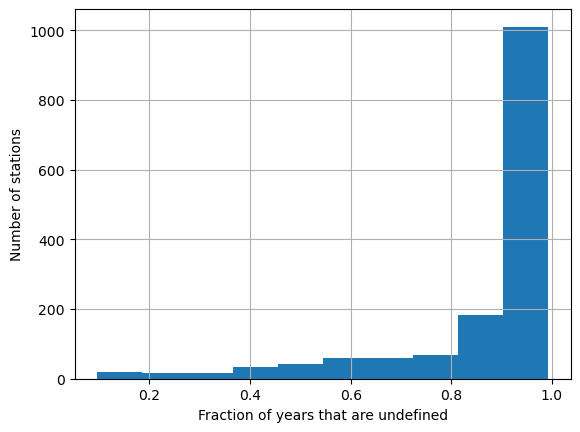

In [8]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

Text(0, 0.5, 'fraction of stations that are undefined')

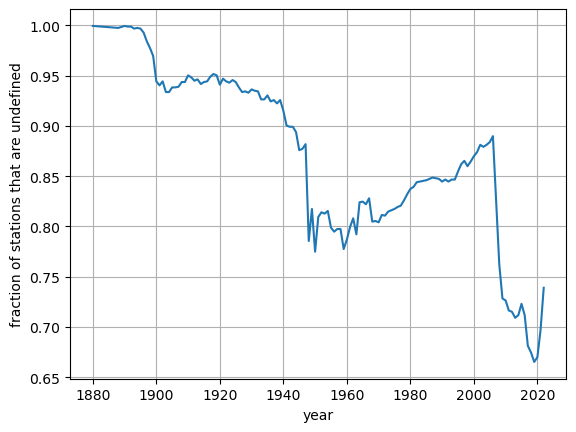

In [9]:
year_nulls=pd.isnull(year_station_table).mean(axis=1)
year_nulls.plot();
grid()
ylabel('fraction of stations that are undefined')

In [10]:
pdf2=pdf[pdf['year']>1960]
year_station_table=pdf2.pivot(index='year', columns='station', values='coeff_2')
year_station_table.tail(5)

station,US1NYAB0001,US1NYAB0006,US1NYAB0010,US1NYAB0016,US1NYAB0021,US1NYAB0022,US1NYAB0023,US1NYAB0025,US1NYAB0028,US1NYAB0032,...,USW00054790,USW00064776,USW00094725,USW00094728,USW00094733,USW00094740,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
2018,-971.259732,-31.420069,-2.725126,NaN,-310.500205,NaN,-551.346264,NaN,NaN,-59.205343,...,NaN,-195.734243,NaN,-244.632435,NaN,-219.849642,NaN,-226.716226,373.360900,NaN
2019,21.911582,3.865887,1.881955,NaN,-94.416242,NaN,153.801254,NaN,NaN,1.222621,...,NaN,-185.716878,NaN,-291.709164,NaN,-180.333499,NaN,-277.823987,0.335587,NaN
2020,162.934900,NaN,0.318085,NaN,-207.460436,NaN,-242.322141,NaN,NaN,0.599232,...,NaN,NaN,NaN,-253.386990,NaN,NaN,NaN,-257.134325,NaN,NaN
2021,272.389446,NaN,-6.088038,NaN,69.424530,NaN,119.285450,NaN,NaN,-8.564681,...,NaN,NaN,NaN,59.094631,NaN,NaN,NaN,46.324398,NaN,NaN
2022,275.131390,NaN,1.373080,NaN,-169.532332,NaN,-29.564078,NaN,NaN,4.253823,...,NaN,NaN,NaN,-143.174042,NaN,NaN,NaN,-114.678107,NaN,NaN


Text(0, 0.5, 'Number of stations')

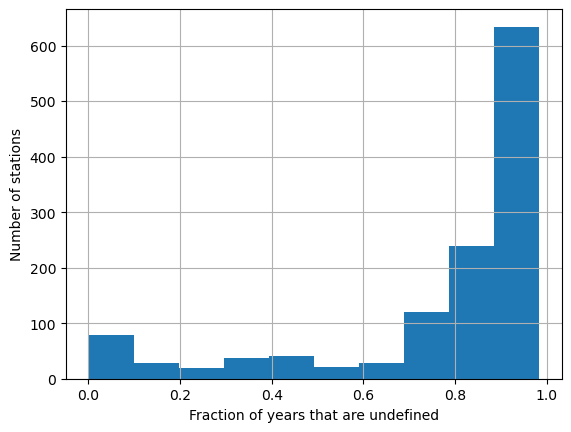

In [11]:
station_nulls=pd.isnull(year_station_table).mean()
station_nulls.hist();
xlabel('Fraction of years that are undefined')
ylabel('Number of stations')

### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the second eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

In [12]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_year=np.nanmean(year_station_table,axis=1)
mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station

print('total RMS                   = ',RMS(year_station_table))
print('RMS removing mean-by-station= ',RMS(tbl_minus_station),'reduction=',RMS(year_station_table)-RMS(tbl_minus_station))
print('RMS removing mean-by-year   = ',RMS(tbl_minus_year),'reduction=',RMS(year_station_table)-RMS(tbl_minus_year))

total RMS                   =  489.524439882916
RMS removing mean-by-station=  466.3497380540662 reduction= 23.174701828849777
RMS removing mean-by-year   =  400.56360877189684 reduction= 88.96083111101916


### Conclusion Of Analysis
The effect of time is about four times as large as the effect of location.

### Iterative reduction
* After removing one component, the other component can have an effect.
* We can use **alternating minimization** to remove the combined effect of location and time.

In [13]:
T=year_station_table
print('initial RMS=',RMS(T))
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    std_by_year=np.nanstd(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print(i,'after removing mean by year    =',RMS(T))
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print(i,'after removing mean by stations=',RMS(T))

initial RMS= 489.524439882916
0 after removing mean by year    = 400.56360877189684
0 after removing mean by stations= 377.0618726106545
1 after removing mean by year    = 376.9834108042794
1 after removing mean by stations= 376.96797710124497
2 after removing mean by year    = 376.96074510568275
2 after removing mean by stations= 376.9562378360024
3 after removing mean by year    = 376.9532516568049
3 after removing mean by stations= 376.9512457701175
4 after removing mean by year    = 376.94989312806547
4 after removing mean by stations= 376.94897974011


Text(0.5, 1.0, 'mean as a function of year')

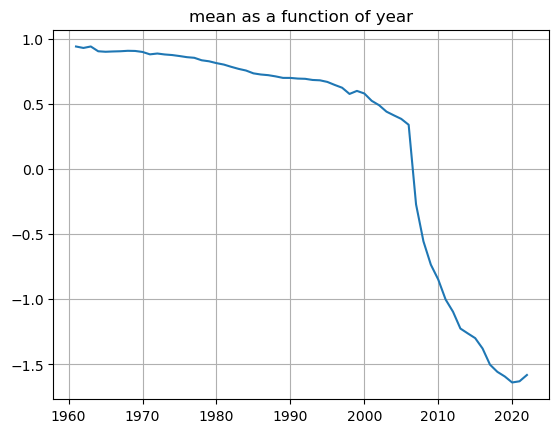

In [14]:
years=list(T.index)
plot(years,mean_by_year)
grid()
title('mean as a function of year')

### Is this conclusion justified ?

Check the graph for individual stations

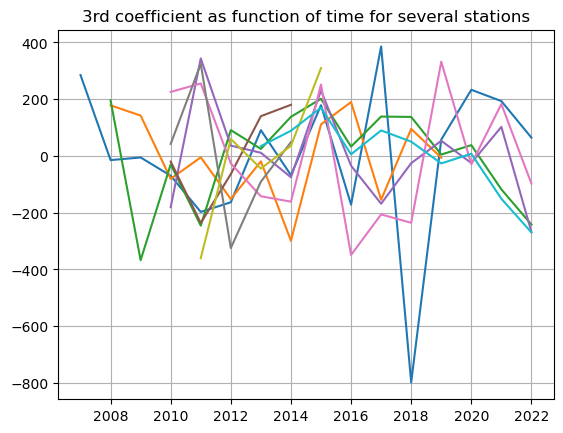

In [15]:
for i in range(10):
    plot(years,T.iloc[:,i])
grid()
title('3rd coefficient as function of time for several stations');

## Summary
* The problem of missing data is prevalent and needs to be addressed.
* RMS can be used to quantify the effect of different factors (here, time vs. space)
* The snow season in NY seems to be getting earlier and earlier since 1960.
* but the high variance places doubt on this conclusion.